# **Factory Machine Failure Classification**

Author: Kaleb Nim

## Project Objective:

> Using Machine Learning classification model to solve Binary Class classification problem: Predict if a Machine will fail or machine remains normal functional



### Background information 
Dataset collected from a factory environment. Inside the factory, there are 
many machines and components, and they might break down after using for some 
time. Therefore, it is useful to build a prediction model in order to predict which 
machine / component will possibly fail before it actually fails, so that the technician can 
replace it without interruption the production.

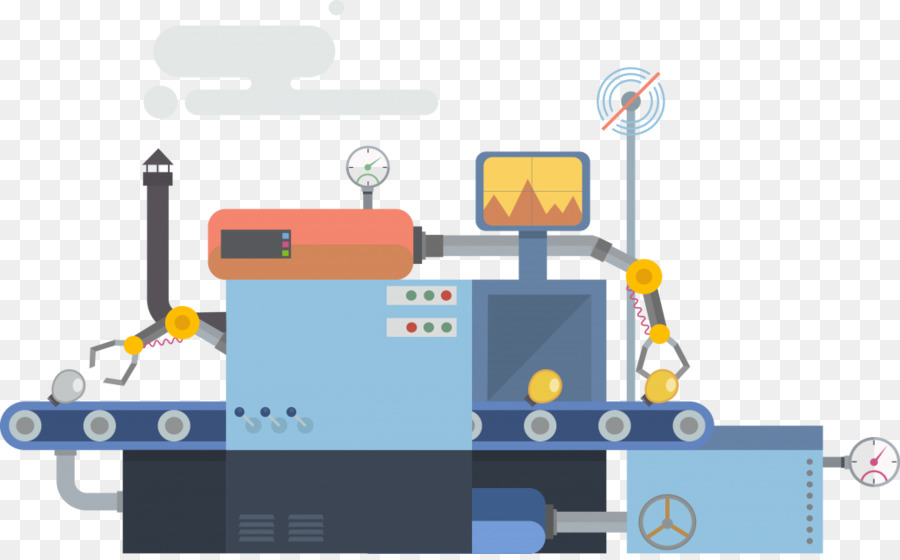

# **Project Initilzation**

## Importing Libraries

In [5]:
# !pip uninstall sklearn -y
# !pip install Cython
# !pip install -U scikit-learn
# !pip install phik


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import time as time
# Models
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, learning_curve ,cross_val_score ,GridSearchCV,KFold,RandomizedSearchCV

# algorithm family :D 
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression ,RidgeClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor, ExtraTreesClassifier ,AdaBoostClassifier
import xgboost

import sklearn
print(sklearn.__version__)
# Date preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer ,SimpleImputer ,IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler ,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Model Evaluation Metrics
from sklearn.metrics import fbeta_score, make_scorer,classification_report,confusion_matrix, roc_auc_score, f1_score ,plot_confusion_matrix ,accuracy_score,recall_score,precision_score,plot_roc_curve,fbeta_score
# progress bar
from tqdm import tqdm

# Bivariative Analysis
# !pip install phik
import phik
from phik import resources, report

1.0.2


## Loading Dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df_raw = pd.read_csv('Datasets/factory_data (classification).csv')
df_raw.head()

Unique ID Product ID Quality  Ambient T (C)  Process T (C)  \
0          1     K12965       M          24.95          35.45   
1          2     Z62710       L          25.05          35.55   
2          3     T20224       L          24.95          35.35   
3          4     Z33024       L          25.05          35.45   
4          5     Z52839       L          25.05          35.55   

   Rotation Speed (rpm)  Torque (Nm)  Tool Wear (min)  Machine Status  
0                1551.0         42.8                0               0  
1                1408.0         46.3                3               0  
2                1498.0         49.4                5               0  
3                1433.0         39.5                7               0  
4                1408.0         40.0                9               0

## Data Dictonary

|     **Column**     	|                                **Description**                               	|
|:------------------:	|:----------------------------------------------------------------------------:	|
| Unique ID          	| Unique identifier ranging from 1 to 20000                                    	|
| Product ID         	| The serial number of product                                                 	|
| Quality            	| Consist of letter L, M and H for low, medium and high quality                	|
| Ambient T          	| Environment temperature in degree celsius                                    	|
| Process T          	| Machine temperature                                                          	|
| Rotation Speed     	| Rotational speed of machine when running                                     	|
| Torque             	| Measure of the turning force                                                 	|
| Tool Wear          	| Tool wear time estimated for the machine                                     	|
| **Machine Status** 	| **Labels indicate machine failure or not, 1 means failure, 0 means normal.** 	|

# Prevent Data Leakage 



> **Data leakage** is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.
Reference : [data-leakage-machine-learning](https://machinelearningmastery.com/data-leakage-machine-learning/)

To takle this problem I'll be creating a **Holdout Dataset** that will be left untouched in all data preprocessing and model training to act as a final sanity check of my finalizated model.


In [9]:
train_df,test_df = train_test_split(df_raw,test_size=0.2,random_state=1)
print(f'Shape of train_df:{train_df.shape}\nShape of test_df:{test_df.shape}')

Shape of train_df:(16000, 9)
Shape of test_df:(4000, 9)


# **Exploratory Data Analysis**

A good data science project starts from understanding our data. With that, I 
will perform some basic visualisation to spot some trends between features and target variable `Machine status` and errors in the Machine dataset.

---

To prevent the mutation of our original data, we will make a copy of our data to perform eda on it.

*EDA process will only be analysed to the train_df*




In [10]:
df_eda = train_df.copy()

## Descriptive Statistics

In [11]:
df_eda.shape

(16000, 9)

There are **16k** rows and **9** Features in the training factory datset

In [12]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 7013 to 235
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unique ID             16000 non-null  int64  
 1   Product ID            16000 non-null  object 
 2   Quality               15208 non-null  object 
 3   Ambient T (C)         16000 non-null  float64
 4   Process T (C)         15687 non-null  float64
 5   Rotation Speed (rpm)  15055 non-null  float64
 6   Torque (Nm)           16000 non-null  float64
 7   Tool Wear (min)       16000 non-null  int64  
 8   Machine Status        16000 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 1.2+ MB


It is to be noted that features:

`Unique ID`,`Ambient T (C)`, `Process T (C)`, `Rotation Speed (rpm)`,`Torque (Nm)` and `Tool Wear (min)` are **Quantitative** features

`Quality` is a **ordinal valued categorical** feature

`Product ID` **Norminal valued** categorical feature

## Pairplot

Since our feature space is not extremely large, we can afford to plot out a Pairplot to visualise the distribution of datapoints with relation to Target variable `Machine Status` 

I hope to Answer the following questions:



1.   Is there a noticable pattern relating Machine Status with Quantitave variables like Ambient T and Process T
2.   List item



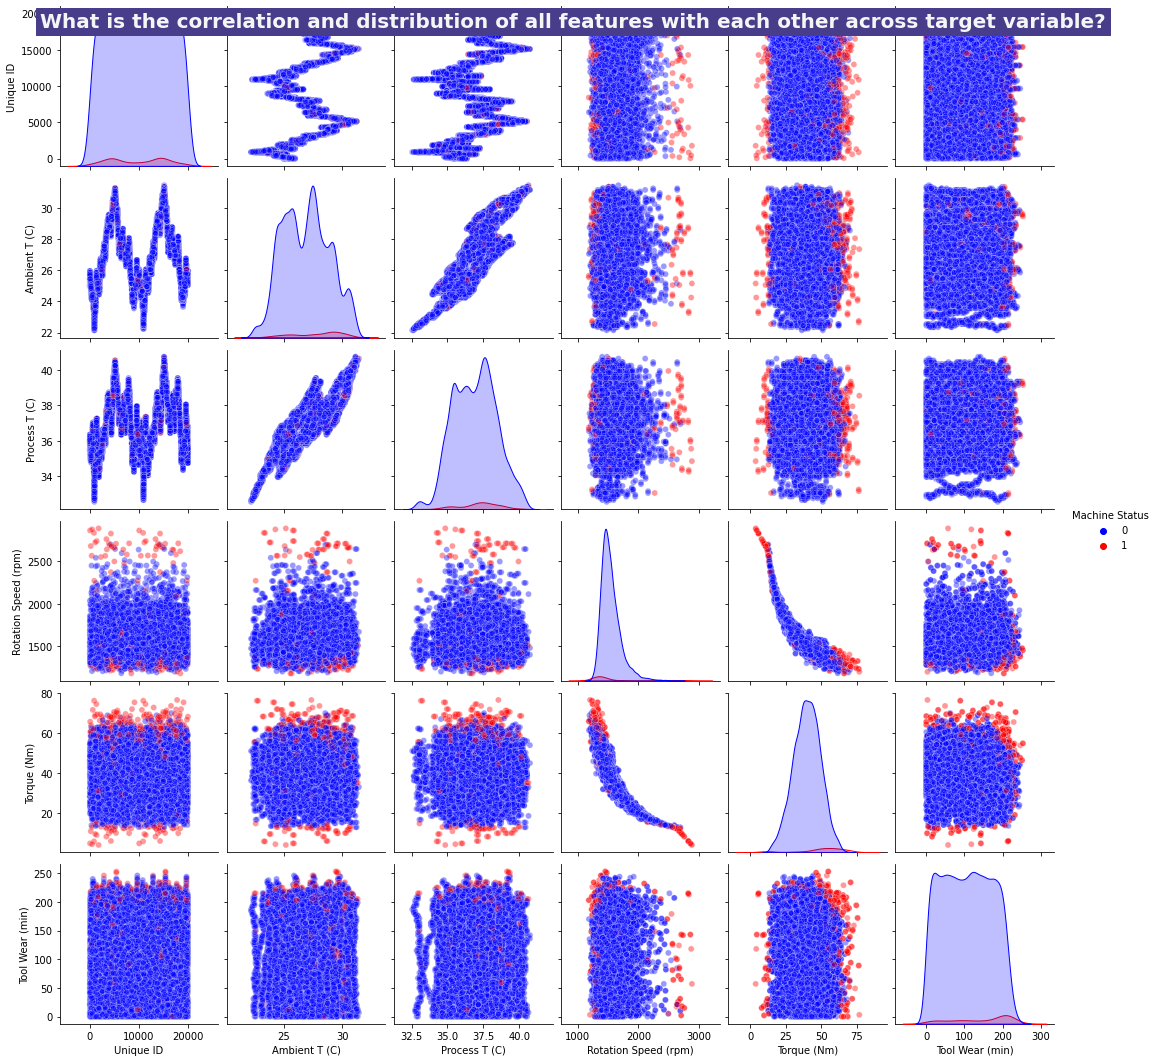

In [13]:
g = sns.pairplot(df_eda.drop(columns=['Product ID']), hue = 'Machine Status', palette=['b', 'r'], plot_kws=dict(alpha=0.4))
# Add title
g.fig.suptitle("What is the correlation and distribution of all features with each other across target variable?", color='whitesmoke',weight='bold',size=20, backgroundcolor= 'darkslateblue')
plt.show()

### Pairplot Observations:



*   Generally, Machine failure occurs at extreme ends of features
*   A pattern whereby alot of Machine Failure occurs when `Torque` is above 70Nm or below 20Nm. This can be seen across all other features 
*   A similar pattern can also be seen with extreme values of `Rotation speed` above 2500Rpm and around below 1300rpm



## Distribution of features across Machine Status ( fail and normal )

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

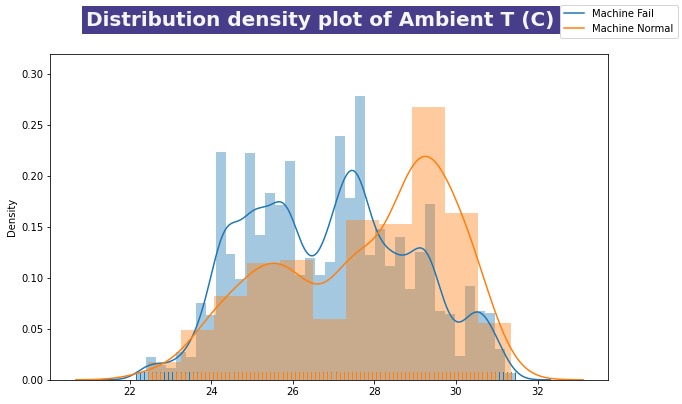

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

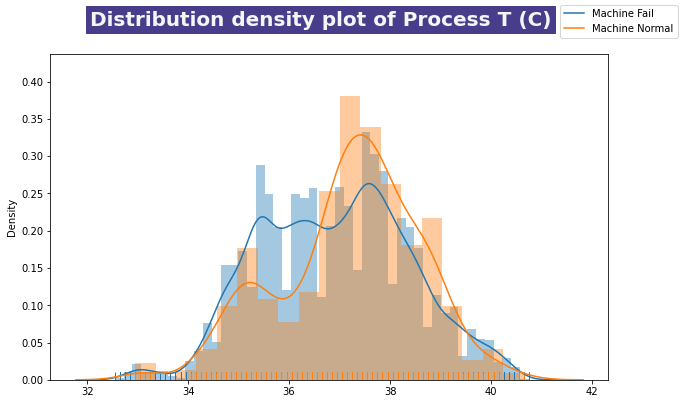

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

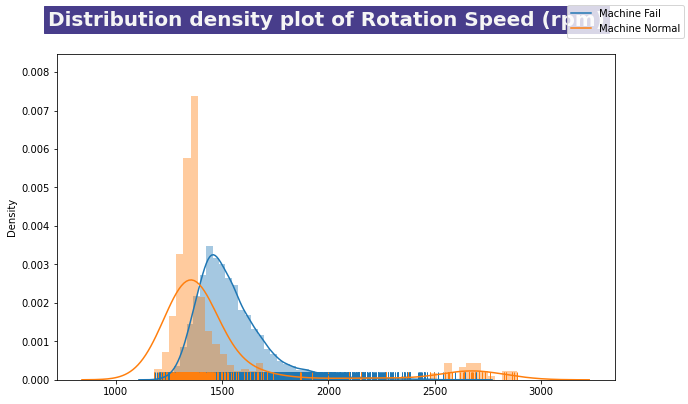

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

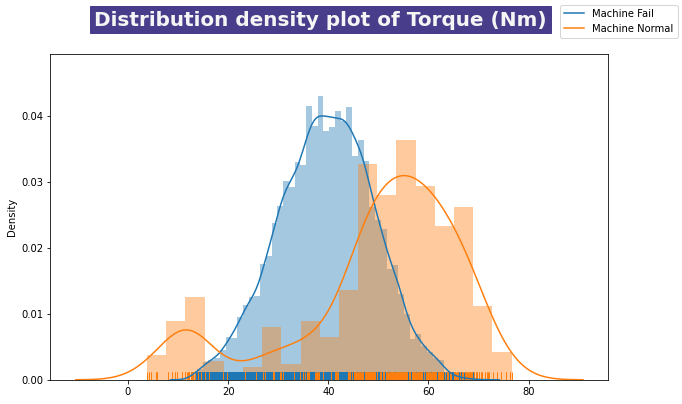

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

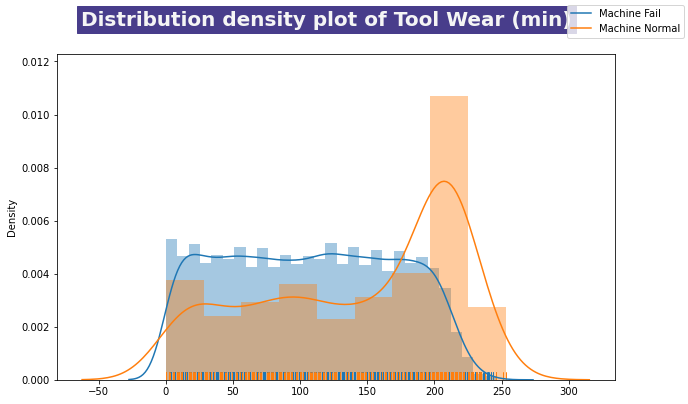

In [14]:
df_eda_fail = df_eda[df_eda['Machine Status']==0]
df_eda_normal = df_eda[df_eda['Machine Status']==1]

# df_eda_melt = df_eda.melt(['Machine Status'],value_vars=['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)','Torque (Nm)'], var_name='cols',  value_name='vals')

features = ['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)','Torque (Nm)','Tool Wear (min)']

for i in features:
  fig = plt.figure(figsize=(10,6))
  sns.distplot(df_eda_fail[[i]], hist=True, rug=True)
  sns.distplot(df_eda_normal[[i]], hist=True, rug=True)

  fig.suptitle(f'Distribution density plot of {i}',color='whitesmoke',weight='bold',size=20, backgroundcolor= 'darkslateblue')

  fig.legend(labels=['Machine Fail','Machine Normal'])
  plt.show()
# # g = sns.FacetGrid(df_eda_melt, col='cols', hue="Machine Status", palette="Set1")
# # g = (g.map(sns.distplot, "vals", hist=True, rug=True))

# fig = plt.figure(figsize=(10,6))
# sns.distplot(df_eda_fail[['Torque (Nm)']], hist=True, rug=True)
# sns.distplot(df_eda_normal[['Torque (Nm)']], hist=True, rug=True)

# fig.suptitle('Distribution density plot of Torque (Nm)',color='whitesmoke',weight='bold',size=20, backgroundcolor= 'darkslateblue')
# fig.legend(labels=['Machine Fail','Machine Normal'])
# plt.show()


Adding new Features for EDA: 

In [15]:
df_eda['Product_Group'] = df_eda['Product ID'].str[0]

df_eda['horsepower'] = df_eda['Torque (Nm)']*(df_eda['Rotation Speed (rpm)']/5255)

df_eda

Unique ID Product ID Quality  Ambient T (C)  Process T (C)  \
7013        7014     S64754       M          27.25          37.25   
7766        7767     Z87315       L          27.15          38.25   
5910        5911     S72586       M          27.65          37.15   
7020        7021     K71289       L          27.65          37.65   
16952      16953     S36007       L          27.75          38.25   
...          ...        ...     ...            ...            ...   
10955      10956     T88713       L          22.55          33.25   
17289      17290     S42919       L          27.25          37.55   
5192        5193     T12990       L          30.75          39.95   
12172      12173     K65498       L          26.45          36.15   
235          236     Z75727       M          24.95          35.15   

       Rotation Speed (rpm)  Torque (Nm)  Tool Wear (min)  Machine Status  \
7013                 1544.0         36.3               21               0   
7766                 1318.0         52.7               13               0   
5910                 1458.0         43.4                0               0   
7020                 1460.0         53.8               41               0   
16952                1498.0         40.2               73               0   
...                     ...          ...              ...             ...   
10955                1911.0         20.9               74               0   
17289                1433.0         53.8               86               0   
5192                 1310.0         62.9              130               0   
12172                   NaN         23.0               15               0   
235                  1680.0         33.7              185               0   

      Product_Group  horsepower  
7013              S   10.665500  
7766              Z   13.217621  
5910              S   12.041332  
7020              K   14.947288  
16952             S   11.459486  
...             ...         ...  
10955             T    7.600362  
17289             S   14.670866  
5192              T   15.680114  
12172             K         NaN  
235               Z   10.773739  

[16000 rows x 11 columns]

## Bi-variate Analysis -Phik correlation 𝜙k

Phik correlation (𝜙k) is the latest relatively new correlation metric that is based on several refinements to Pearson’s χ2 (chi-squared) contingency test

Unfortunately there’s isn’t a closed forum formula . Therefore let see a visual representation of how Phik correlation works

This is how Phik compares to pearson's p and cramer's p correlation metric
 
[Phik](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)

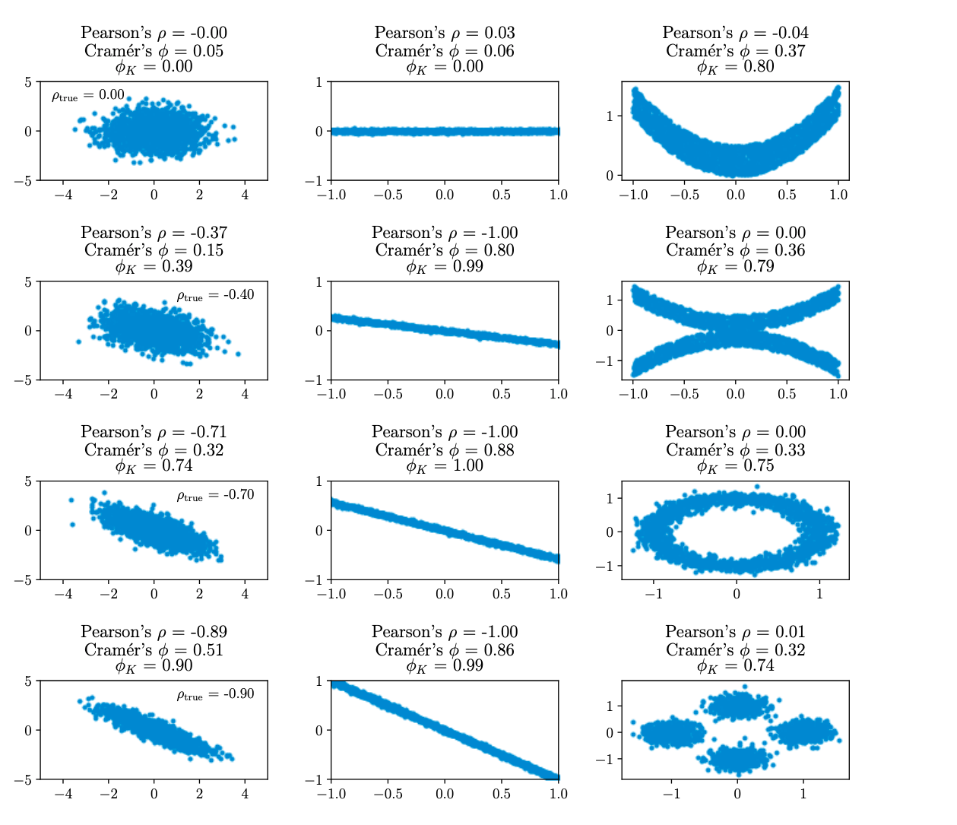

In [16]:
df_eda.phik_matrix()

interval columns not set, guessing: ['Unique ID', 'Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'Machine Status', 'horsepower']


/usr/local/lib/python3.7/dist-packages/phik/data_quality.py:62: UserWarning: The number of unique values of variable Product ID is large: 15621. Are you sure this is not an interval variable? Analysis for pairs of variables including Product ID can be slow.
  col, df[col].nunique()


Unique ID  Product ID   Quality  Ambient T (C)  \
Unique ID              1.000000    0.262634  0.024757       0.856041   
Product ID             0.262634    1.000000  0.000000       0.000000   
Quality                0.024757    0.000000  1.000000       0.038477   
Ambient T (C)          0.856041    0.000000  0.038477       1.000000   
Process T (C)          0.759167    0.000000  0.038276       0.924075   
Rotation Speed (rpm)   0.053805    0.668248  0.034503       0.074725   
Torque (Nm)            0.000000    0.796228  0.030879       0.080081   
Tool Wear (min)        0.000000    0.000000  0.000000       0.114700   
Machine Status         0.148457    0.000000  0.020323       0.152627   
Product_Group          0.014564    1.000000  0.000000       0.012732   
horsepower             0.000000    0.886782  0.012743       0.057021   

                      Process T (C)  Rotation Speed (rpm)  Torque (Nm)  \
Unique ID                  0.759167              0.053805     0.000000   
Product ID                 0.000000              0.668248     0.796228   
Quality                    0.038276              0.034503     0.030879   
Ambient T (C)              0.924075              0.074725     0.080081   
Process T (C)              1.000000              0.070861     0.064725   
Rotation Speed (rpm)       0.070861              1.000000     0.937281   
Torque (Nm)                0.064725              0.937281     1.000000   
Tool Wear (min)            0.121721              0.066125     0.054576   
Machine Status             0.084732              0.466114     0.600269   
Product_Group              0.000000              0.000000     0.009653   
horsepower                 0.074191              0.919240     0.974955   

                      Tool Wear (min)  Machine Status  Product_Group  \
Unique ID                    0.000000        0.148457       0.014564   
Product ID                   0.000000        0.000000       1.000000   
Quality                      0.000000        0.020323       0.000000   
Ambient T (C)                0.114700        0.152627       0.012732   
Process T (C)                0.121721        0.084732       0.000000   
Rotation Speed (rpm)         0.066125        0.466114       0.000000   
Torque (Nm)                  0.054576        0.600269       0.009653   
Tool Wear (min)              1.000000        0.275976       0.028047   
Machine Status               0.275976        1.000000       0.004852   
Product_Group                0.028047        0.004852       1.000000   
horsepower                   0.080505        0.576867       0.016480   

                      horsepower  
Unique ID               0.000000  
Product ID              0.886782  
Quality                 0.012743  
Ambient T (C)           0.057021  
Process T (C)           0.074191  
Rotation Speed (rpm)    0.919240  
Torque (Nm)             0.974955  
Tool Wear (min)         0.080505  
Machine Status          0.576867  
Product_Group           0.016480  
horsepower              1.000000

interval columns not set, guessing: ['Unique ID', 'Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'Machine Status', 'horsepower']


/usr/local/lib/python3.7/dist-packages/phik/data_quality.py:62: UserWarning: The number of unique values of variable Product ID is large: 15621. Are you sure this is not an interval variable? Analysis for pairs of variables including Product ID can be slow.
  col, df[col].nunique()


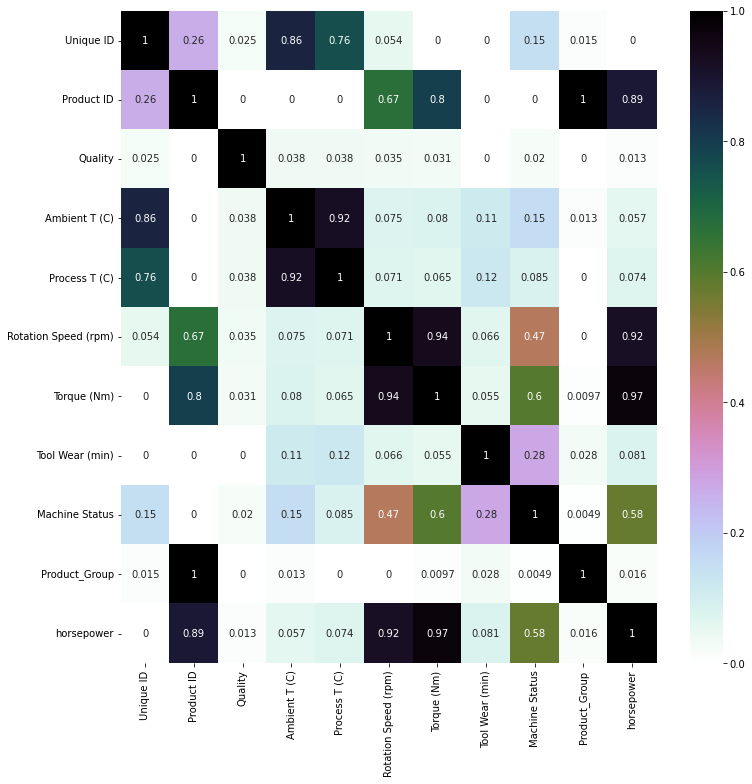

In [17]:
plt.figure(figsize=(12,12))
sns.heatmap(
    df_eda.phik_matrix(),
    cmap="cubehelix_r",
    annot = True)
plt.show()

Observations:

* Torque and Rotation Speed has the highest correlation compared to all other features at 0.60𝜙k and 0.46𝜙k respectively

* Ambient T (C) and Process T (C) is highly correlated to each other at 0.92𝜙k

* Torque (Nm) and Rotation Speed (rpm) are also highly correlated to each other at 0.93𝜙k

This is supported by the pairplot graphs. 

## Groups of Quality across Machine Status

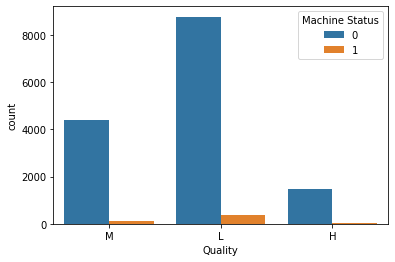

In [18]:
sns.countplot(data=df_eda,x='Quality',hue='Machine Status')

## Outlier Values

## Distribution of Target Variable

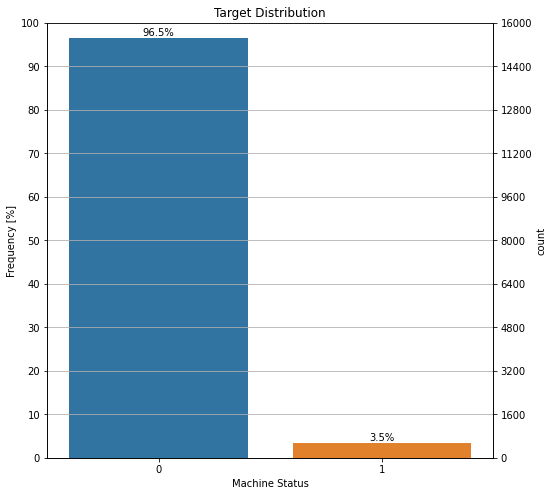

In [19]:
import matplotlib.ticker as ticker

ncount = len(df_eda)

plt.figure(figsize=(8,8))
ax = sns.countplot(x="Machine Status", data=df_eda)
plt.title('Target Distribution')

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

### Observations:

> Our Target Feature `Machine Status` has an extremely **unbalanced distribution** of observations i.e No Machine faiilure has a very high number of observations whereas Machine failure has a very low number of observations at 96.5% and 3.5% respectively

From this we can conclude that we are working with an **Imbalanced dataset**

Thus we have to be carefull when selecting a Evaluation Metric for our models. ( more will be explaned in the Evalutaion Metric selction of this workbook ) 


## Checking for Null Values

In [20]:
null_features = df_eda.isna().sum() > 0 
print(df_eda.isna().sum()[null_features])

Quality                 792
Process T (C)           313
Rotation Speed (rpm)    945
horsepower              945
dtype: int64


### Visuallizing Null values

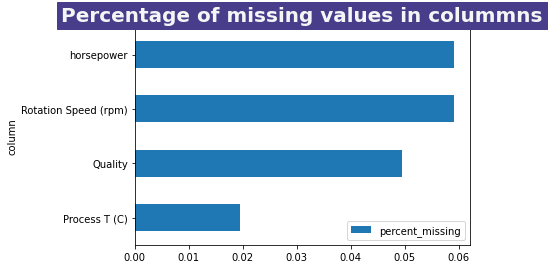

In [21]:
def plot_missing_values(df):
    """ For each column with missing values plot proportion that is missing."""
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    missing_df.plot(kind='barh', x='column', y='percent_missing'); 
    plt.title('Percentage of missing values in colummns',color='whitesmoke',weight='bold',size=20, backgroundcolor= 'darkslateblue');

plot_missing_values(df_eda)

Conclusions: Imputation neccasary in Feature Processing

# **Feature Processing**

In [22]:
df = train_df.copy()

## Drop usless feature


By dropping features that has no predictive power on Machine status will allow me to accomplish the following:

*   Reduce Overfitting 

    Less redundant data means less opportunity to make decisions based on noise --> Improves Accuracy

*   Reduce the computational cost of modeling

    Less data means that algorithms train faster.


### Which features to drop?

Based on above EDA, 
`ProductID` has a 0.00 Phik correlation score and `UniqueID` has a 0.08 in the 

*   `ProductID` has a 0.00 Phik correlation score thus will **drop**.
*   `UniqueID` is a unique identifier.Hence, logically will have no predictive power. However it has a 0.15 𝜙k correlation score to Machine Status hence ill choose to **keep** it.

Conclusion:

Only drop `Product ID`

In [23]:
# Drop columns ProductID and Process T (C)
df = df.drop(['Product ID'], axis = 1) 

## Adding new feature

Since we found out that `Product Group` has no predictive power ( from EDA ) we wont be adding `Product Group` into our test and validation datasets.


Thus We will be adding only one new feature:

`Horsepower`: 

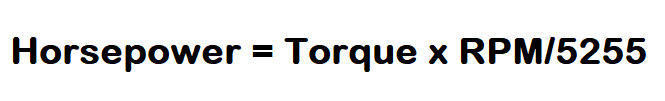


In [24]:
df['horsepower'] = df['Torque (Nm)']*(df['Rotation Speed (rpm)']/5255)



In [25]:
df.columns

Index(['Unique ID', 'Quality', 'Ambient T (C)', 'Process T (C)',
       'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)',
       'Machine Status', 'horsepower'],
      dtype='object')

## Data Partition 

Using sklearn Train_test_split We will be spliting out training dataset into two sets

*   Training set
*   Validation Set

We will be follwing the conventional the **80%-20% split** for our dataset. We can come back and alter the ratio if needed.


#### Extracting Features, `X` and Target Variable, `y`

In [26]:
X = df.drop(columns=['Machine Status'])
y = df['Machine Status']

In [27]:
X

Unique ID Quality  Ambient T (C)  Process T (C)  Rotation Speed (rpm)  \
7013        7014       M          27.25          37.25                1544.0   
7766        7767       L          27.15          38.25                1318.0   
5910        5911       M          27.65          37.15                1458.0   
7020        7021       L          27.65          37.65                1460.0   
16952      16953       L          27.75          38.25                1498.0   
...          ...     ...            ...            ...                   ...   
10955      10956       L          22.55          33.25                1911.0   
17289      17290       L          27.25          37.55                1433.0   
5192        5193       L          30.75          39.95                1310.0   
12172      12173       L          26.45          36.15                   NaN   
235          236       M          24.95          35.15                1680.0   

       Torque (Nm)  Tool Wear (min)  horsepower  
7013          36.3               21   10.665500  
7766          52.7               13   13.217621  
5910          43.4                0   12.041332  
7020          53.8               41   14.947288  
16952         40.2               73   11.459486  
...            ...              ...         ...  
10955         20.9               74    7.600362  
17289         53.8               86   14.670866  
5192          62.9              130   15.680114  
12172         23.0               15         NaN  
235           33.7              185   10.773739  

[16000 rows x 8 columns]

In [28]:
y

7013     0
7766     0
5910     0
7020     0
16952    0
        ..
10955    0
17289    0
5192     0
12172    0
235      0
Name: Machine Status, Length: 16000, dtype: int64

## Train Test Split 

In [29]:
# Import train_test_split function from sklearn library

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=42)

# Save a copy of un processed X_train and X_test for pipeline integration
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

In [30]:
print(X_train.shape,X_test.shape)

(11200, 8) (4800, 8)


Features `Quailty` , `Process T (C)` and `Rotation Speed (rpm)` have missing values

 ## Handling Missing Values 
There's a few ways we could go about handing missing values



1.   Dropping entire rows with Missing values
2.   Impute with Central Tendency ( Mean, Median, Mode )
3.   Impute with Advanced Algorithm in SKLearn ( IterativeImputer, KNNImputer )


EXPLAIN WHY U CHOOSE WHAT KAY



In [31]:
# All Numerical Features that has missing Values
num_cols = [
'Rotation Speed (rpm)',
'Process T (C)',
'horsepower'
]

# initialize Imputer
imputer = IterativeImputer()
imputed = imputer.fit_transform(X_train[num_cols])

X_train.loc[:, num_cols] = imputed

imputed = imputer.transform(X_test[num_cols])

X_test.loc[:,num_cols] = imputed

In [32]:
X_train.isna().sum()

Unique ID                 0
Quality                 552
Ambient T (C)             0
Process T (C)             0
Rotation Speed (rpm)      0
Torque (Nm)               0
Tool Wear (min)           0
horsepower                0
dtype: int64

In [33]:
# Categorical Features that has missing Values 

cat_cols = ['Quality']

# Initialze Imputer by most Frequent
imp = SimpleImputer(strategy='most_frequent')
imputed_cat = imp.fit_transform(X_train[cat_cols])

X_train.loc[:, cat_cols] = imputed_cat

imputed_cat = imp.transform(X_test[cat_cols])

X_test.loc[:,cat_cols] = imputed_cat

In [34]:
X_test.isna().sum()

Unique ID               0
Quality                 0
Ambient T (C)           0
Process T (C)           0
Rotation Speed (rpm)    0
Torque (Nm)             0
Tool Wear (min)         0
horsepower              0
dtype: int64

Adding 

In [35]:
X_train

Unique ID Quality  Ambient T (C)  Process T (C)  Rotation Speed (rpm)  \
73            74       L          25.85          35.95           1539.258925   
19495      19496       H          26.25          36.95           1373.000000   
16437      16438       L          27.35          36.95           1282.000000   
11582      11583       H          25.05          35.25           1530.000000   
9116        9117       H          24.45          35.55           1659.000000   
...          ...     ...            ...            ...                   ...   
1082        1083       H          23.95          34.75           1420.000000   
4555        4556       L          29.55          37.45           1690.000000   
13391      13392       L          28.45          37.65           1541.842257   
8667        8668       M          24.35          35.65           1455.000000   
24            25       M          25.85          36.25           1539.714807   

       Torque (Nm)  Tool Wear (min)  horsepower  
73            35.0              200   11.409741  
19495         44.8              221   11.705119  
16437         66.1               40   16.125633  
11582         42.0              184   12.228354  
9116          32.1               49   10.133949  
...            ...              ...         ...  
1082          39.8              192   10.754710  
4555          26.7                4    8.586679  
13391         47.3               77   11.392372  
8667          46.1              147   12.764129  
24            37.3               70   11.406676  

[11200 rows x 8 columns]

## Normalizing Data

Normalizing or preprocessing the data will help many models perform better
after this is done. 
( Except Tree Models as it treats each feature on its own )


### For this particular dataset I'm are going to **Standardize** the data. 



> Standardizing is translating the data so that it has a mean value of zero and a standard deviation of one. Refrence: [Data Standardization](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/#:~:text=Standardizing%20a%20dataset%20involves%20rescaling,value%20or%20centering%20the%20data.)



This way models don’t treat variables with larger scales as more
important than smaller scaled variables.

In [36]:
# Initialize StandardScaler class
scaler = StandardScaler()

num_col = ['Unique ID',"Ambient T (C)" ,"Rotation Speed (rpm)", "Torque (Nm)", "Tool Wear (min)","horsepower",'Process T (C)']

# Save a copy of X_train before Standardization to plot before and after for comparism 
X_train_copy = X_train.copy()

# Fit and transform training and test sets to standardize numercial values 
X_train[num_col] = scaler.fit_transform(X_train[num_col] )
X_test[num_col] = scaler.fit_transform(X_test[num_col] )

### End ###
X_train

Unique ID Quality  Ambient T (C)  Process T (C)  Rotation Speed (rpm)  \
73     -1.729682       L      -0.540491      -0.660418             -0.008288   
19495   1.636895       H      -0.339462       0.023560             -0.947429   
16437   1.106826       L       0.213369       0.023560             -1.461458   
11582   0.265269       H      -0.942550      -1.139204             -0.060589   
9116   -0.162184       H      -1.244094      -0.934010              0.668089   
...          ...     ...            ...            ...                   ...   
1082   -1.554784       H      -1.495381      -1.481193             -0.681942   
4555   -0.952780       L       1.319032       0.365550              0.843198   
13391   0.578838       L       0.766201       0.502345              0.006304   
8667   -0.240013       M      -1.294352      -0.865612             -0.484239   
24     -1.738176       M      -0.540491      -0.455225             -0.005713   

       Torque (Nm)  Tool Wear (min)  horsepower  
73       -0.489496         1.446877    0.005201  
19495     0.488676         1.776523    0.160921  
16437     2.614702        -1.064712    2.491374  
11582     0.209198         1.195718    0.436766  
9116     -0.778955        -0.923435   -0.667385  
...            ...              ...         ...  
1082     -0.010391         1.321298   -0.340125  
4555     -1.317947        -1.629820   -1.483090  
13391     0.738209        -0.483907   -0.003956  
8667      0.618433         0.614913    0.719221  
24       -0.259925        -0.593789    0.003585  

[11200 rows x 8 columns]

### Visuallazing Standardization

By plotting a histogram of distribution of any one of the numerical features before Standardized and after Standardized

In [37]:
# Using Feature Torque (Nm) Before Standardization
import plotly.express as px
df = px.data.tips()
fig = px.histogram(X_train_copy, x="Torque (Nm)", nbins=30,title="Distribution of Torque (Nm) Before Standardization")
fig.show()

In [38]:
# Using Feature Torque (Nm) after Standardization
import plotly.express as px
df = px.data.tips()
fig = px.histogram(X_train, x="Torque (Nm)", nbins=30,title="Distribution of Torque (Nm) After Standardization")
fig.show()

### **Observations**:

Even though the shape of distribution of Torque didn't change, the X-axis values changed. 

After Standardization, 

*   mean value has change from 40 to 0
*   Range from (10 --> 70) to (-3 --> 3)



## Feature Encoding

ML models we are often required to convert the categorical i.e text features to its numeric representation.

We have two choices for Categorical Encoding 



*   One-Hot-Encoding
*   Label Encoding

The feature we want to encode is `Quality`. Which consists of `['L', 'H', 'M']` ( as seen below ) stands for Low Medium and High Quality respectively

Conclusion: Since `Quality` is a Ordinal feature, we will choose **Label Encoding** as we want the model to derive a correlation between the Quality number increases and machine failure prediction

In [39]:
#List unique value of flat_type with unique()
display(X_train['Quality'].unique())

array(['L', 'H', 'M'], dtype=object)

In [40]:

from sklearn.preprocessing import LabelEncoder
encoded = LabelEncoder()
encoded.fit([
        ['L'],
        ['M'],
        ['H']
    ])

X_encoded_train = encoded.fit_transform(X_train[["Quality"]])
X_encoded_test = encoded.fit_transform(X_test[["Quality"]])

### End ###
X_train['Quality'] = X_encoded_train
X_test['Quality'] = X_encoded_test
X_train

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Unique ID  Quality  Ambient T (C)  Process T (C)  Rotation Speed (rpm)  \
73     -1.729682        1      -0.540491      -0.660418             -0.008288   
19495   1.636895        0      -0.339462       0.023560             -0.947429   
16437   1.106826        1       0.213369       0.023560             -1.461458   
11582   0.265269        0      -0.942550      -1.139204             -0.060589   
9116   -0.162184        0      -1.244094      -0.934010              0.668089   
...          ...      ...            ...            ...                   ...   
1082   -1.554784        0      -1.495381      -1.481193             -0.681942   
4555   -0.952780        1       1.319032       0.365550              0.843198   
13391   0.578838        1       0.766201       0.502345              0.006304   
8667   -0.240013        2      -1.294352      -0.865612             -0.484239   
24     -1.738176        2      -0.540491      -0.455225             -0.005713   

       Torque (Nm)  Tool Wear (min)  horsepower  
73       -0.489496         1.446877    0.005201  
19495     0.488676         1.776523    0.160921  
16437     2.614702        -1.064712    2.491374  
11582     0.209198         1.195718    0.436766  
9116     -0.778955        -0.923435   -0.667385  
...            ...              ...         ...  
1082     -0.010391         1.321298   -0.340125  
4555     -1.317947        -1.629820   -1.483090  
13391     0.738209        -0.483907   -0.003956  
8667      0.618433         0.614913    0.719221  
24       -0.259925        -0.593789    0.003585  

[11200 rows x 8 columns]

Phew now that done here's a meme cus why not

 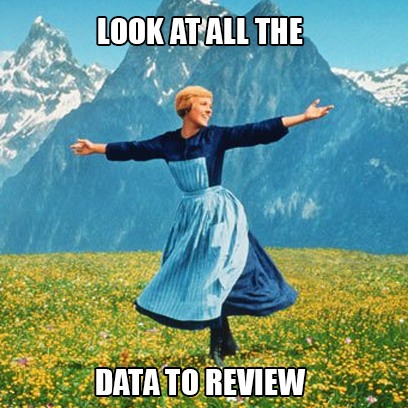

# **Modelling**

We will be using pipelines to smoothen the process

## Selecting Evaluation Metrics

As we seen in our EDA above the dataset is highly imbalanced with 96.5% machines being functional and only 3.5% machine failure. Which can cause some issue

For example using **Accuracy score**: 

> The model predicts all machines are functional. The model will be highly evaluated with accuracy score of 96.5% even though its absolutely horrenderous at the main goal of predicting machine failure.

Since our goal is to build a model to succesfully **predict Machine Failure** --> we need a metrics that heavily penalized FP ( false positives ) i.e Model predicts machine is functional but actual result is machine failure (FP) 

A Machine failing before it can be maintained will result in a halt in production which will decrease company productivity. This is exactly what we want to stop

We will use the following confusion Matric 

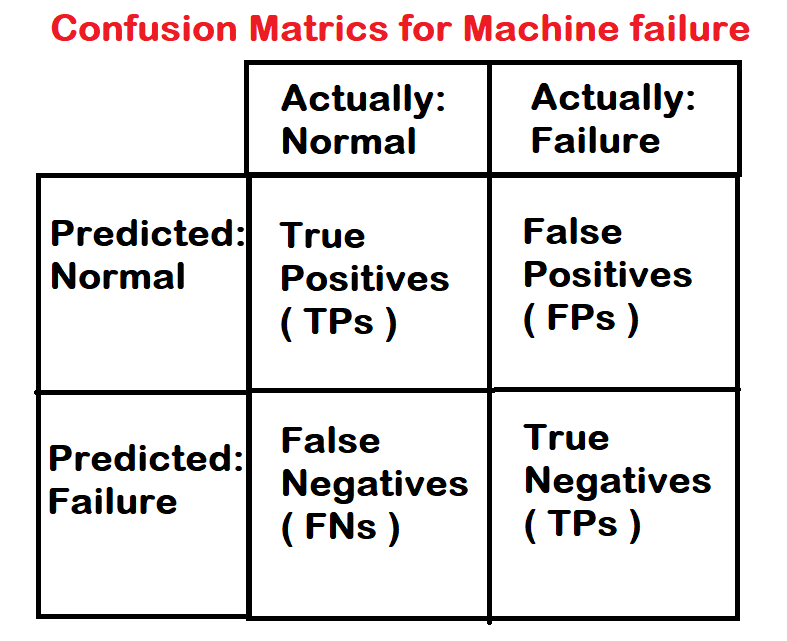

A Machine failing before it can be maintained will result in a halt in production which will decrease company productivity. This is exactly what we want to stop

### List of all the possible evalutation Metrics


*   Accuracy

    - Percent of correct predictions

* precision
    - Ability to find only relevant samples (not label a negative
      as a positive)

* recall
  - Ability to find all positive samples

*  'f1-score'
    - Harmonic mean of precision and recall

* **'fβ-score'**
    - Same as f1-score but able to assign different weights to prescision and recall 

* 'roc_auc'
    - Area under the receiver operator characteristic curve

* Precision-Recall Curve


We will use *fβ-score* as our main evaluation metric as it gives us the flexiblilty to assign weights to prescision. With beta=0.5 which will weigh prescision 2x heavier than recall. 

---



## Stupid Baseline Model

We will be using sklearn `DummyClassifier` as a baseline classifier. 
The `DummyClassifier`is a good baseline as it makes predictions that ignore the input features


Qn: Which strategy should we use as the baseline for Dummyclassifier? 

We will run through the all 5 strategies of the `DummyClassifier` and choose the best model

In [41]:
def display_dummy_classidier(X_train,y_train,X_test,y_test,strategy=str):
  dummy_clf = DummyClassifier(strategy="uniform")
  dummy_clf.fit(X_train, y_train)
  DummyClassifier(strategy=strategy)
  prediction = dummy_clf.predict(X_test)
  # print(f"Test F1 Score\t:{f1_score(y_test,prediction)}") # Test F1 Score
  print(f"Strategy:{strategy}\n{classification_report(y_test, prediction, target_names=['train','test'])}\n")

strategies = ["most_frequent", "prior", "stratified", "uniform", "constant"]
start_time = time.time()

for i in strategies:
  display_dummy_classidier(X_train,y_train,X_test,y_test,strategy=i)

  
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Strategy:most_frequent
              precision    recall  f1-score   support

       train       0.96      0.51      0.66      4619
        test       0.04      0.46      0.07       181

    accuracy                           0.51      4800
   macro avg       0.50      0.49      0.36      4800
weighted avg       0.93      0.50      0.64      4800


Strategy:prior
              precision    recall  f1-score   support

       train       0.96      0.51      0.66      4619
        test       0.04      0.49      0.07       181

    accuracy                           0.51      4800
   macro avg       0.50      0.50      0.37      4800
weighted avg       0.93      0.51      0.64      4800


Strategy:stratified
              precision    recall  f1-score   support

       train       0.97      0.50      0.66      4619
        test       0.04      0.57      0.08       181

    accuracy                           0.50      4800
   macro avg       0.51      0.53      0.37      4800
weighted avg  

Conclusion:

Since strategy `most frequent` has a slightly higher f1 test score ( honestly insignificant )  than the other strategies, we shall select `most frequent` as our strategy for further comparison with other models .

---



# **Model Selection**


## How do we select the best model for this project?



1.  ### Low Variance

1.  ### Low Bias
2.  ### High interpretability
4. ### High Evalutaion Metric performance
  * Chosen metric: fβ-score


## How do identify those points listed above?

*   ### Learning Curve

  *  Analyze/explore the bias and variance of a model. --> Check Model Underfitted/Overfitted

*  ### 5-Fold Cross-Validation
  * Used as our **Evaluation Strategy**. Avoid overfitting and estimate the skill of the model on new data.
  CV training scores be used to compare with test scores to identify variance

## More on Learning Curve

A learning Curve Determines cross-validated training and test scores for different training set sizes  

[Sklearn Learning Curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html)

By plotting a Learning Curve, we can analyze the bias and variance of a model.
[MachineLearningMastery_Learning Curve](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/)

## Quick Evalutation Function

We will incoperate fitting the model,cross validation on test set, generating predictions on validation set ,and plotting Learning Curve into one function in which multiple models can be evaluated at once.

CV train scores and test scores will be recorded down in history

In [42]:
# Function 
def quick_evalutaion(models, X_train, X_test, y_train, y_test,metrics=["precision","recall","f1","roc_auc"],curve = False, cv = KFold(n_splits=5,shuffle=True,random_state=1)):
    hist = {}
    
    for idx, model in (enumerate(models)):
        try:
            clf = model(random_state=42,class_weight='balanced') # Setting random_state for certain model + set class rate to balanced (imbalanced dataset ) 
        except:
            clf = model()
        clf.fit(X_train, y_train)
        test_prediction = clf.predict(X_test) # Testing on validation dataset

        # Test dataset
        f1_test = f1_score(y_test, test_prediction,zero_division=1)
        f1_beta = fbeta_score(y_test, test_prediction,zero_division=1,beta= 0.5) # 𝛽 = 2, weighs Precision higher than Recall.
        test_recall = recall_score(y_test,test_prediction)
        test_prescision = precision_score(y_test,test_prediction)
        test_roc_auc_score = roc_auc_score(y_test,test_prediction)

        # 5-Fold CV
        cv_hist = cross_validate(clf, X_train, y_train, scoring=metrics,verbose=1)

        # Record down the performance
        hist[model.__name__] = dict(
            # train_acc = acc_train,
            cv_precision = cv_hist['test_precision'].mean(),
            prescision_test_score = test_prescision,
            cv_recall = cv_hist['test_recall'].mean(),
            recall_test_score = test_recall,
            cv_auc = cv_hist['test_roc_auc'].mean(),
            auc_score = test_roc_auc_score,
            cv_f1_score = cv_hist['test_f1'].mean(),
            f1_test_score = f1_test,
            f1_beta_test_score = f1_beta,

        )

        # Plotting the learning Curve of each Model using: F1_score
        if curve:
          fig, ax = plt.subplots(figsize=(10, 8))
          train_sizes = np.linspace(.1, 1.0, 10)
          train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring="f1")
          scores = pd.DataFrame({
          "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
          "Train Scores" : train_scores.flatten(),
          "Test Scores" : test_scores.flatten()
          }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
          # print(f"THis is train_sizes:\n{train_sizes}\n This is train_scores:\n{train_scores}\n This is test_scores:{test_scores}")
          sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax,palette=['#3DD5E2', '#A045B5'])
          ax.set_title(f"Learning Curve of {model}")
          ax.set_ylabel("f1_score")
          ax.set_xlabel("Train Sizes")
          plt.show()
      
    results = pd.DataFrame(hist).T
    return results
    # plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` paramete

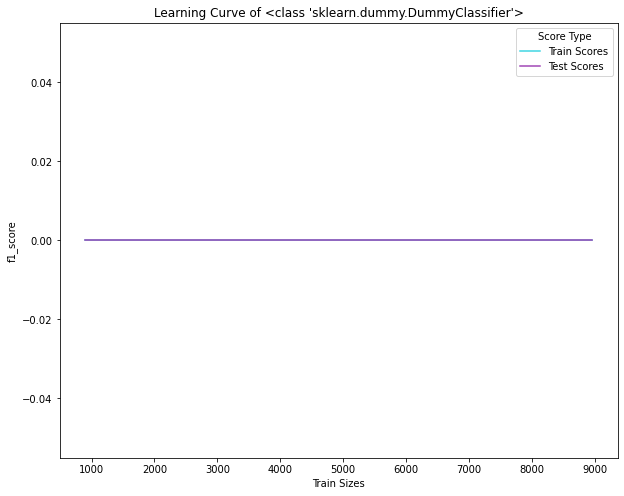

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


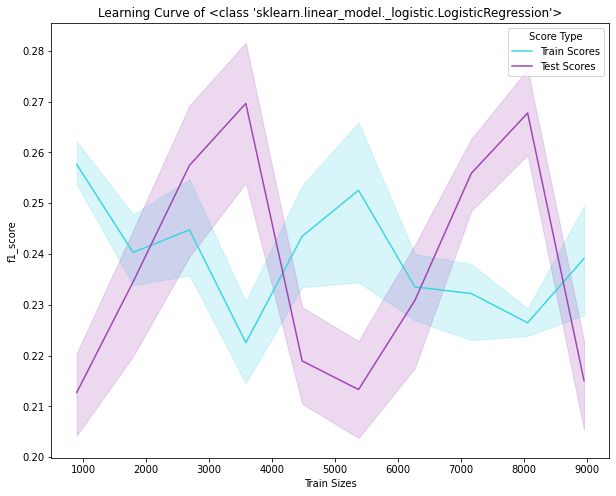

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


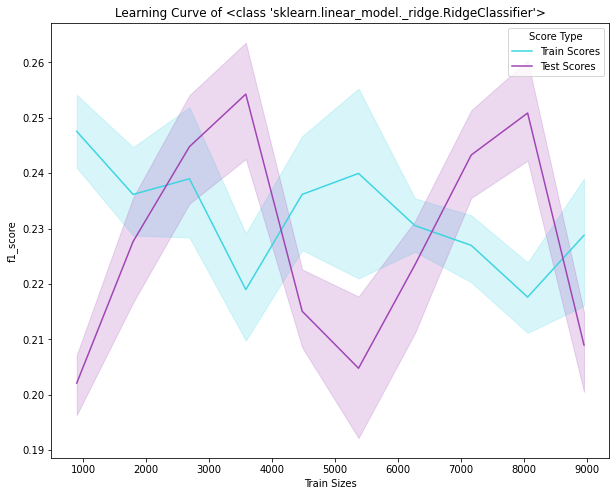

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


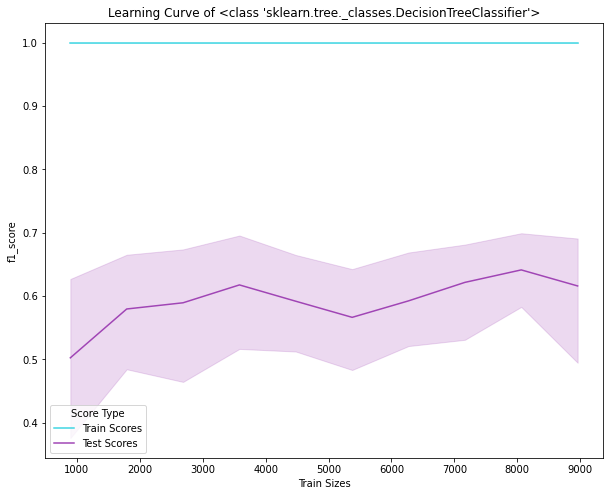

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s finished


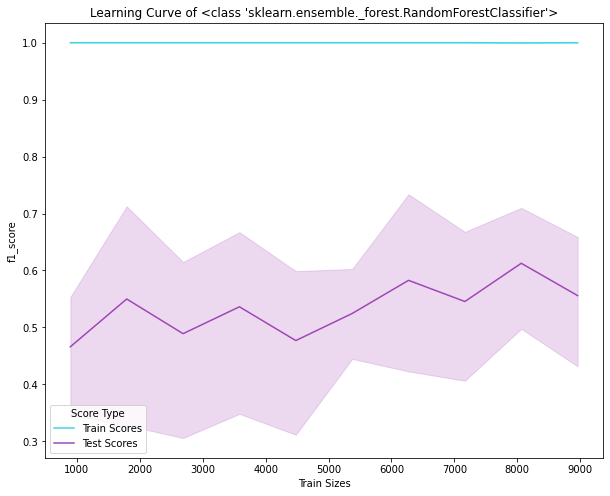

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


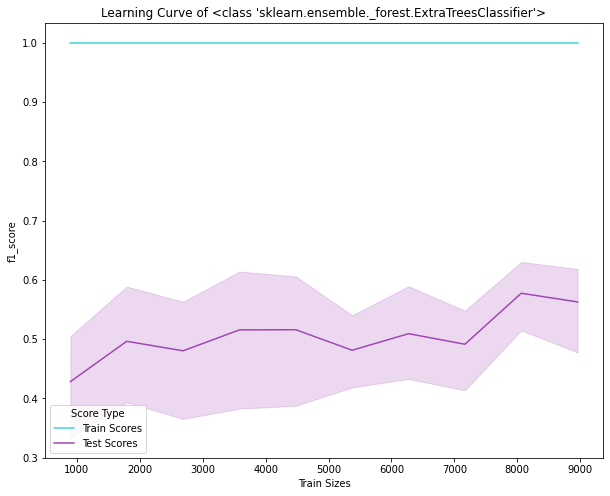

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


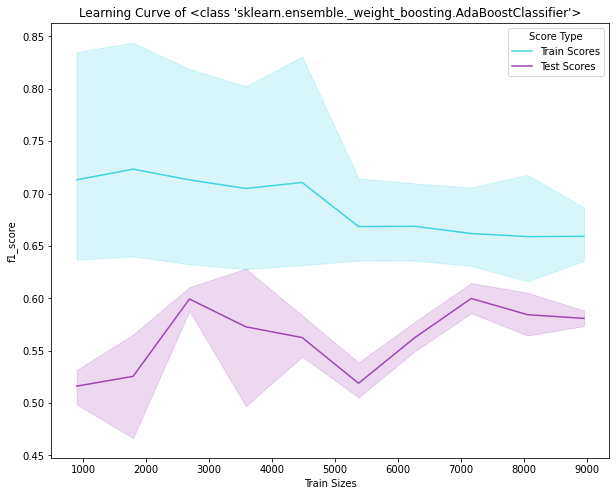

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


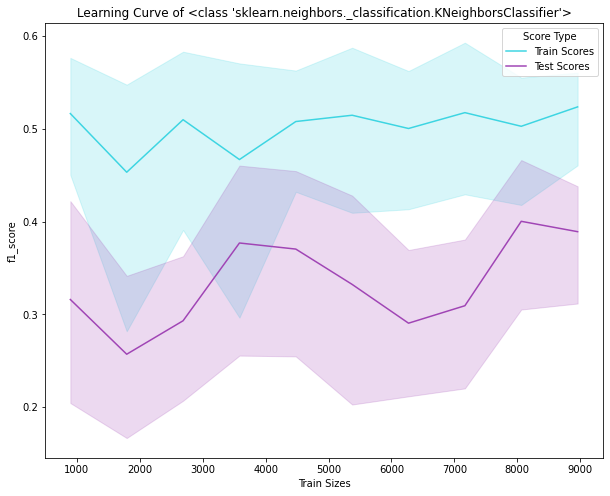

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.7s finished


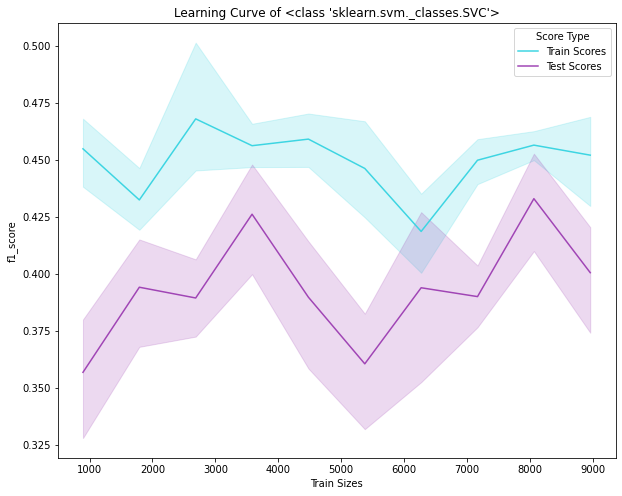

In [43]:
models = [DummyClassifier,LogisticRegression,RidgeClassifier,DecisionTreeClassifier, RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,KNeighborsClassifier ,SVC,]

eval = quick_evalutaion(models, X_train, X_test, y_train, y_test,curve=True)
eval.style.apply(lambda x: ['background-color: #83F48E; color: black' if v else '' for v in x == x.max()]).apply(lambda x: ['background-color: #FA6F63; color: black' if v else '' for v in x == x.min()])


# Model Improvement : RandomForestClassifier	

smt smt add on later: We can see that RandomForestClassifier performed the best with cv_f1_score of: ______ 

We will try to improve the score of RandomForestClassifier smt smt smt

However RandomForestClassifier shows signs of Overfitting.
Hence, we will attempt to reduce the variance of these learning algorithms.

## Pipeline 
To simplfy the data processing methods we shall use a pipeline to complie all the steps. The use of pipleline also help prevent data leakage 

Pipeline Members:

1. ColumnTransformer : Split between different pipeline for categorical features(to be one-hot encoded) and numerical features(to be normalised).
2. Simple Imputer: Impute Categorical features; strategy = most frequent
3. Iterative Imputer: Impute  Numerical Features
2. OneHotEncoder : Convert Categorical Features into dummy variables (drop ='first').
3. StandardScaler : Ensures all features are at the same scale of mean = 0, standard deviation = 1
4. Final Predictor : Tree-based Regressor

In [44]:
cat_features = ['Quality']
num_features = ['Unique ID',"Ambient T (C)" ,"Rotation Speed (rpm)", "Torque (Nm)", "Tool Wear (min)",'Process T (C)','horsepower']


num_features_pipe = Pipeline([
    ('Itertive_impute',IterativeImputer()),
    ("scaler", StandardScaler())
])


cat_features_pipe = Pipeline([
    ('simple_impute',SimpleImputer(strategy='most_frequent')),                     
    ("onehot", OneHotEncoder(drop='first'))
])


prep_pipe = ColumnTransformer([
    ("num", num_features_pipe, num_features),
    ("cat", cat_features_pipe, cat_features)
])


pipe = Pipeline([
    ("preprocess", prep_pipe),
    ("estimator", RandomForestClassifier(random_state = 12,class_weight='balanced'))
])

In [45]:
pipe.fit(X_train_raw,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Itertive_impute',
                                                                   IterativeImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Unique ID', 'Ambient T (C)',
                                                   'Rotation Speed (rpm)',
                                                   'Torque (Nm)',
                                                   'Tool Wear (min)',
                                                   'Process T (C)',
                                                   'horsepower']),
                                                 ('cat',
                                                  Pipeline(steps=[('simple_impute',
     

## Oversampling 

As we have seen from our EDA process the Machine Dataset is Highly imbalanced with 96.5% of the positive class 

To tackle this, we will be attempting a type of data augmentation for the minority class, referred to as the **RandomOverSampler**

This bascially will generate new data points where Machine Status failed using features from pre-existing data points

We will be trying out two

In [48]:
import plotly.express as px
# df = px.data.iris()
fig = px.scatter(df_eda, x="Torque (Nm)", y="Rotation Speed (rpm)", color="Machine Status",title= 'Distribution of Machine Status across Torque and Rotation speed BEFORE OVERSAMPLE')
fig.show()

In [49]:

# testing with these dataframes first
over_X_train = X_train.copy()
over_y_train = y_train.copy()
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE,BorderlineSMOTE ,RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

# # define dataset
# X_train, y_train = make_classification(n_samples=10000, n_features=2, n_redundant=0,
# 	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# testing with these dataframes first
over_X_train = X_train.copy()
over_y_train = y_train.copy()

# summarize class distribution
counter = Counter(over_y_train)
print(f'Machine Status distribution BEFORE oversample:\n {counter}')

# define pipeline
over = RandomOverSampler(sampling_strategy='minority')
# under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

# transform the dataset
over_X_train, over_y_train = pipeline.fit_resample(over_X_train, over_y_train)

# summarize the new class distribution
counter = Counter(over_y_train)
print(f'Machine Status distribution AFTER oversample:\n {counter}')

df_oversample = pd.concat([over_X_train, over_y_train],axis=1)
df_oversample.head()
# scatter plot of examples by class label

fig = px.scatter(df_oversample, x="Torque (Nm)", y="Rotation Speed (rpm)", color="Machine Status",title= 'Distribution of Machine Status across Torque and Rotation speed AFTER OVERSAMPLE USING RandomOverSampler')
fig.show()

Machine Status distribution BEFORE oversample:
 Counter({0: 10822, 1: 378})
Machine Status distribution AFTER oversample:
 Counter({0: 10822, 1: 10822})


Since we can only visualize a 2D plane, i just chose Torque and Rotation speed as both features have the highest correlation to Machine Status

In [50]:
# Function 
def single_evalutaion(pipeline, X_train, X_test, y_train, y_test,metrics=["precision","recall","f1","roc_auc"],curve = False, cv = KFold(n_splits=5,shuffle=True,random_state=1)):
    hist = {}

    pipeline.fit(X_train, y_train)
    test_prediction = pipeline.predict(X_test) # Testing on validation dataset

    # Test dataset
    f1_test = f1_score(y_test, test_prediction,zero_division=1)
    f1_beta = fbeta_score(y_test, test_prediction,zero_division=1,beta= 0.5) # 𝛽 = 2, weighs Precision higher than Recall.
    test_recall = recall_score(y_test,test_prediction)
    test_prescision = precision_score(y_test,test_prediction)
    test_roc_auc_score = roc_auc_score(y_test,test_prediction)

    # 5-Fold CV
    cv_hist = cross_validate(pipeline, X_train, y_train, scoring=metrics,verbose=1)

    # Record down the performance
    hist['RandomForestClassifier(Tuned)'] = dict(
    # train_acc = acc_train,
    cv_precision = cv_hist['test_precision'].mean(),
    prescision_test_score = test_prescision,
    cv_recall = cv_hist['test_recall'].mean(),
    recall_test_score = test_recall,
    cv_auc = cv_hist['test_roc_auc'].mean(),
    auc_score = test_roc_auc_score,
    cv_f1_score = cv_hist['test_f1'].mean(),
    f1_test_score = f1_test,
    f1_beta_test_score = f1_beta,

    )

    # Plotting the learning Curve of each Model using: F1_score
    if curve:
      fig, ax = plt.subplots(figsize=(10, 8))
      train_sizes = np.linspace(.1, 1.0, 10)
      train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring="f1")
      scores = pd.DataFrame({
      "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
      "Train Scores" : train_scores.flatten(),
      "Test Scores" : test_scores.flatten()
      }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
      # print(f"THis is train_sizes:\n{train_sizes}\n This is train_scores:\n{train_scores}\n This is test_scores:{test_scores}")
      sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax,palette=['#3DD5E2', '#A045B5'])
      ax.set_title(f"Learning Curve of {model}")
      ax.set_ylabel("f1_score")
      ax.set_xlabel("Train Sizes")
      plt.show()

    # plt.tight_layout()

    # hist.style.apply(lambda x: ['background-color: yellow; color: black' if v else '' for v in x == x.max()]).apply(lambda x: ['background-color: orange; color: black' if v else '' for v in x == x.min()])
    results = pd.DataFrame(hist).T
    return results
    # plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.2s finished


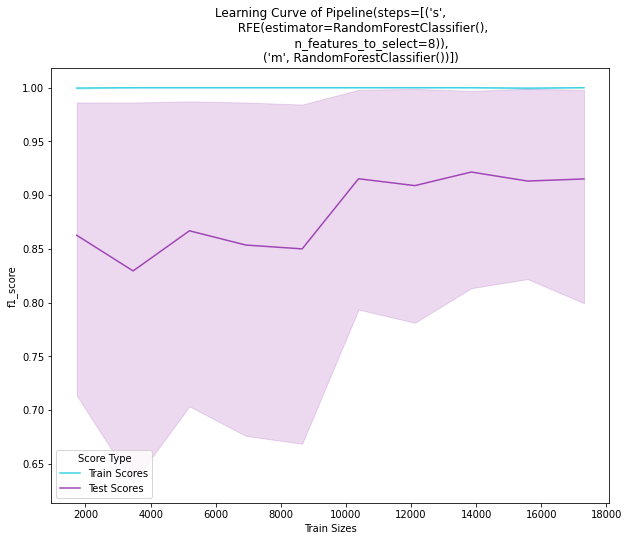

auc_score  cv_auc  cv_f1_score  cv_precision  \
RandomForestClassifier(Tuned)    0.84368     1.0     0.998432       0.99687   

                               cv_recall  f1_beta_test_score  f1_test_score  \
RandomForestClassifier(Tuned)        1.0            0.843455       0.778816   

                               prescision_test_score  recall_test_score  
RandomForestClassifier(Tuned)               0.892857           0.690608

In [57]:
RF = RandomForestClassifier(class_weight='balanced')

single_evalutaion(RF, over_X_train, X_test, over_y_train, y_test,curve=True)

## Comparing Feature Scaling Methods

Initially, we used standardscalar to scale our numerical features to mean=0 s.d=1. Now lets try Other scaling methods and even no 

## Hyper Parameter Tuning

just try out a wide range of values and see what works using Gridsearch techniques

We will try adjusting the following set of hyperparameters:

* n_estimators = number of trees in the foreset

* max_features = max number of features considered for splitting a node

* max_depth = max number of levels in each decision tree

* min_samples_split = min number of data points placed in a node before the node is split

* min_samples_leaf = min number of data points allowed in a leaf node

* bootstrap = method for sampling data points (with or without replacement)

In [58]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Class weight

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 75, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(over_X_train, over_y_train)

rf_random.best_params_

```
Fitting 3 folds for each of 75 candidates, totalling 225 fits
{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}
```

In [ ]:
print("Tuned RandomForest Parameters: {}".format(rf_random.best_params_)) 
print("Best score is {}".format(rf_random.best_score_))

## Feature Selection

We are only going to select features that are useful to the model. As irrlevant features can make more difficult for the model to intepret.

### How to know which features to select?

There we have few methods for feature selection:


*   Collinear Columns
*   Lasso Regression
*  Principal Component Analysis
*  Recursive Feature Elimination

I'll choose Recursive Feature Elimination as my method to feature select that is based on Feature importance



### Recursive Feature Elimination

RFE is a feature selection algorithm. I'll be using RandomforestRegressor to choose the features as it is able to ranking features by importance. Following this I'll fit the remaining features back into RandomforestRegressor and check for improvement to score and variance.

In order to select the optimal number of features to select with RFE. We will hyperparam tune the RFE model to extract out the number of features that has the the highest fβ-score

>1 0.560636 (0.047513)
>2 0.651472 (0.042663)
>3 0.585525 (0.117425)
>4 0.657984 (0.067990)
>5 0.741114 (0.035126)
>6 0.747712 (0.043271)
>7 0.771641 (0.056510)
>8 0.765504 (0.056073)


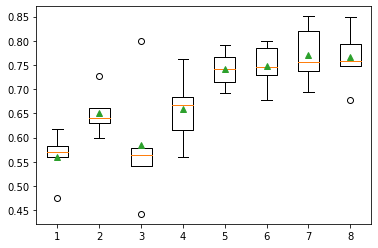

[array([0.47407407, 0.58267717, 0.56953642, 0.61744966, 0.55944056]),
 array([0.6       , 0.66071429, 0.62937063, 0.72727273, 0.64      ]),
 array([0.44210526, 0.54205607, 0.56451613, 0.8       , 0.57894737]),
 array([0.56074766, 0.68376068, 0.61538462, 0.76335878, 0.66666667]),
 array([0.74137931, 0.765625  , 0.71428571, 0.79136691, 0.69291339]),
 array([0.74576271, 0.8       , 0.72992701, 0.78518519, 0.67768595]),
 array([0.73684211, 0.85074627, 0.75555556, 0.82014388, 0.69491525]),
 array([0.74782609, 0.84848485, 0.75912409, 0.79411765, 0.6779661 ])]

In [56]:

# explore the number of selected features for RFE
from numpy import mean
from numpy import std

from sklearn.feature_selection import RFE

 
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1, 9):
		rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=i)
		model = RandomForestClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=5,shuffle=True,random_state=1)
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.6f (%.6f)' % (name, mean(scores), std(scores)))
 
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()
results

Results:
```
>1 0.560636 (0.047513)
>2 0.651472 (0.042663)
>3 0.585525 (0.117425)
>4 0.657984 (0.067990)
>5 0.741114 (0.035126)
>6 0.747712 (0.043271)
>7 0.771641 (0.056510)
>8 0.765504 (0.056073)
```

f1-score keeps improving till 7 features. 

Even though the f1-score for 7 features is very much slightly higher than 8 features, the box plot shows that the standard deviation is lowered.

Hence we will choose to keep all 8 features. No need for feature selection


# Final Model Evaluate

After Improving the model, lets evaluate it.

We will be comparing it to DummyClassifier

In [64]:
final_RF =  Pipeline([
    ("preprocess", prep_pipe),
    ('Recursive Feature elimination',RFE(estimator=RandomForestClassifier(), n_features_to_select=8)),
    ("estimator", RandomForestClassifier(random_state = 12,class_weight='balanced',bootstrap = False,
 max_depth= None,
 max_features = 'sqrt',
 min_samples_leaf = 1,
 min_samples_split= 2,
 n_estimators = 400)) # Optimized params hyperparam tuning stuff here
])

final_RF.fit(X_train_raw, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Itertive_impute',
                                                                   IterativeImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Unique ID', 'Ambient T (C)',
                                                   'Rotation Speed (rpm)',
                                                   'Torque (Nm)',
                                                   'Tool Wear (min)',
                                                   'Process T (C)',
                                                   'horsepower']),
                                                 ('cat',
                                                  Pipeline(steps=[('simple_impute',
     

In [65]:
selected_features = [feature for feature, support in zip(features, final_RF[-2].get_support().flatten()) if support]
removed_features = set(features) - set(selected_features)

In [66]:
selected_features

['Ambient T (C)',
 'Process T (C)',
 'Rotation Speed (rpm)',
 'Torque (Nm)',
 'Tool Wear (min)']

## Create a baseline for comparism

In [54]:
baseline = Pipeline([
    ("preprocess", prep_pipe),
    ('Recursive Feature elimination',RFE(estimator=RandomForestClassifier(), n_features_to_select=11)),
    ("estimator", DummyClassifier(strategy='most_frequent')) # Optimized params hyperparam tuning stuff here
])


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` paramete

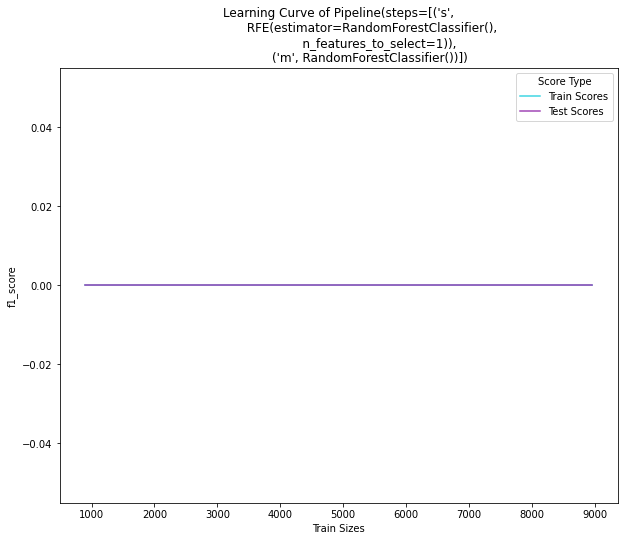

auc_score  cv_auc  cv_f1_score  cv_precision  \
RandomForestClassifier(Tuned)        0.5     0.5          0.0           0.0   

                               cv_recall  f1_beta_test_score  f1_test_score  \
RandomForestClassifier(Tuned)        0.0                 0.0            0.0   

                               prescision_test_score  recall_test_score  
RandomForestClassifier(Tuned)                    0.0                0.0

In [55]:
baseline_results = single_evalutaion(baseline,X_train_raw,X_test_raw,y_train,y_test,curve=True)
display(baseline_results)

In [ ]:
 
Final_history = (single_evalutaion(final_RF,X_train_raw,X_test_raw,y_train,y_test,curve=True))

display(Final_history)

### Final Confusion Matric

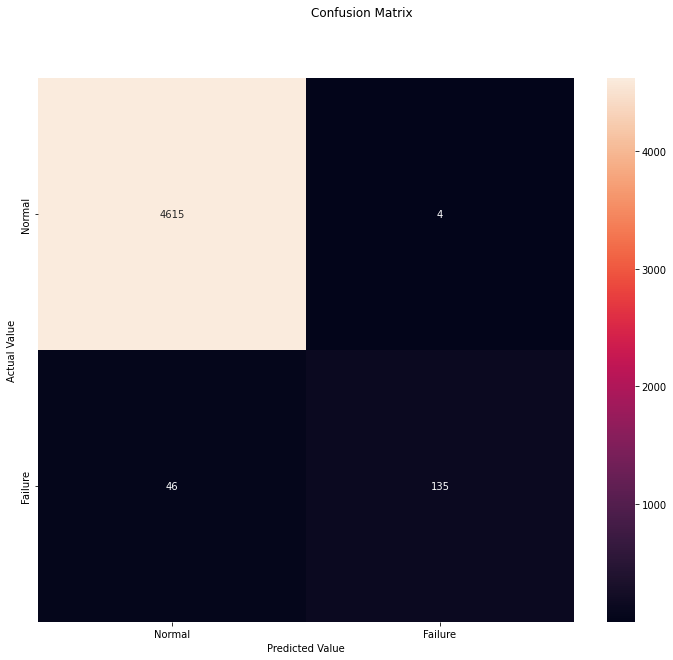

In [72]:
fig, ax = plt.subplots(figsize=(12, 10))
y_pred =final_RF.predict(X_test_raw)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", ax=ax)
ax.set_ylabel("Actual Value")
ax.set_xlabel("Predicted Value")
ax.set_xticklabels(["Normal", "Failure"])
ax.set_yticklabels(["Normal", "Failure"])
fig.suptitle("Confusion Matrix")
plt.savefig("confusion_matrix_mush.png", dpi=600)

Generally we can see that our RandomforestClassifier is able to predict Normal functioning Machines to almost perfection. Only 4 predicted incorrectly out of 4.6k

However, the RandomForestClassifier performs poorly when classifying Machine Failure. around 25% of the time the model predicts a machine failure as Normal.

Since the Main Goal is to predict Machine Failure, I feel the model failed at its main prediction task. This could be due to the over simplicity of the model

# Feature Importance

We can get a better understanding on which features our model consider important, followed up by ranking them.

Text(0.5, 0, 'Feature Name')

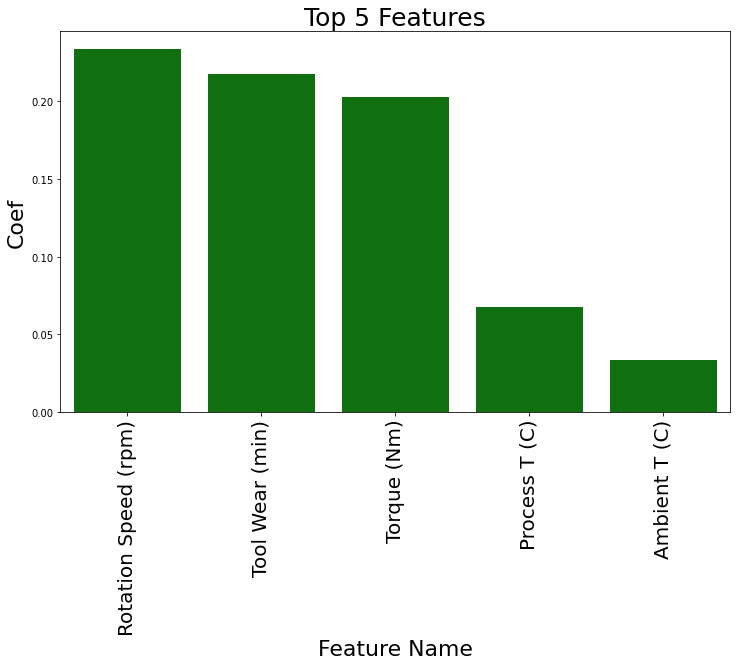

In [71]:
# Get the names of each feature

# Get the coefficients of each feature
coefs = final_RF.named_steps["estimator"].feature_importances_

# Zip coefficients and names together and make a DataFrame
zipped = zip(selected_features, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)


fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 5 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

Our Final  Model RandomForest Classifier ranks Rotation speed the most important feature at 0.25coef followed by Type-Notebook than Weight.

It's surprising that Torque is not the top important features given that it was highly correlated to Machine status in our EDA. 

# Biggest Learning Point

Dealing with Imbalanced classes

It was interesting to find solutions to handle imbalanced classes as I feel its a good skill to know in more useful cases like dealing with card fraud or Spam Email detection. Useful methods like selecting appropriateEvalution metrics, changing model param to "Weighted" and even oversampling methods can be used.  